[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drdave-teaching/OPIM5509Files/blob/main/OPIM5509_Module4_Files/Multivariate_Occupancy_RNN_AdvancedTopics.ipynb)

# Multivariate Example (Advanced Topics)
**Dr. Dave Wanik - University of Connecticut**

Let's see if we can predict if it's an occupancy as a function of environmental data - let's see if Conv1D and MaxPooling1D can make an even better prediction (ConvLSTM).

**Common errors:** forgetting an activation function, not specifying the input shape (or mixing up the order!), not returning sequences when two layers (or accidentally return_sequences=True when only one layer!)


In [ ]:
# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RNN-specific modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

## Read in data
Check for missing values, make some plots.

In [ ]:
# Dataset initially sourced from LuisM78’s GitHub repository:
# url = 'https://raw.githubusercontent.com/LuisM78/Occupancy-detection-data/master/datatest.txt'
# Link to the data file on Github
url = "https://raw.githubusercontent.com/drdave-teaching/OPIM5509Files/refs/heads/main/OPIM5509_Module4_Files/datatest.txt"

# read the data
df = pd.read_csv(url)
print(df.info())
df.head(n=15) # nice complete data! this will allow us to check our work later

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 140 to 2804
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           2665 non-null   object 
 1   Temperature    2665 non-null   float64
 2   Humidity       2665 non-null   float64
 3   Light          2665 non-null   float64
 4   CO2            2665 non-null   float64
 5   HumidityRatio  2665 non-null   float64
 6   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 166.6+ KB
None


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1
145,2015-02-02 14:23:59,23.7600,26.260,568.666667,790.000000,0.004779,1
146,2015-02-02 14:25:00,23.7300,26.290,536.333333,798.000000,0.004776,1
147,2015-02-02 14:25:59,23.7540,26.290,509.000000,797.000000,0.004783,1
148,2015-02-02 14:26:59,23.7540,26.350,476.000000,803.200000,0.004794,1
149,2015-02-02 14:28:00,23.7360,26.390,510.000000,809.000000,0.004796,1


In [ ]:
# count of occupancy
df['Occupancy'].value_counts() # not perfectly balanced, but that's OK

0    1693
1     972
Name: Occupancy, dtype: int64

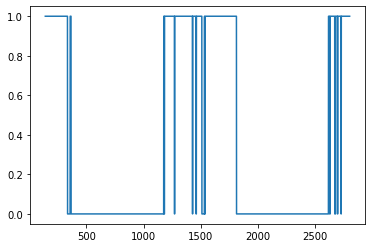

In [ ]:
# visualize the data
df['Occupancy'].plot()
plt.show()

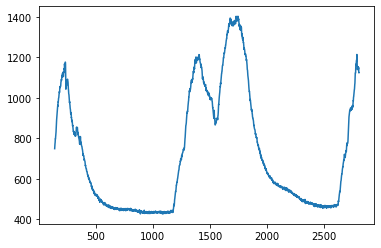

In [ ]:
# visualize the data
df['CO2'].plot()
plt.show()

In [ ]:
# drop the date column
df.drop(['date'], inplace=True, axis=1)
print(df.shape)
df.head()

(2665, 6)


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,23.7000,26.272,585.200000,749.200000,0.004764,1
141,23.7180,26.290,578.400000,760.400000,0.004773,1
142,23.7300,26.230,572.666667,769.666667,0.004765,1
143,23.7225,26.125,493.750000,774.750000,0.004744,1
144,23.7540,26.200,488.600000,779.000000,0.004767,1


In [ ]:
# prep data for modeling (multivariate)
# link: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in np.arange(len(sequences)): # be careful of this line!
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
# we could split our data first, normalize it, then create sequences

In [ ]:
# all we need to do is decide on is n_steps (what our lookback period is)
# since we have a bunch of data, why not n_steps=10? then try 30 later on.
n_steps = 50
raw_seq = np.array(df) #make sure your data is stored as a numpy array!
# let's ignore the date column and just use the temperature data
X, y = split_sequences(raw_seq, n_steps=50)

In [ ]:
# take a peak at what it did
print(X.shape)
print(y.shape)

# scroll up and make sure you understand this!
# y is a function of X (the previous n_steps observations!)

(2616, 50, 5)
(2616,)


In [ ]:
# split the data into train and test partitions
# we will use 50% of the data for train, and 50% for validation
train_pct_index = int(0.5 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# pretty slick way of splitting your data using slicing!
# notice how we didn't do any shuffling (we don't want temporal leakage! keeps time series intact)

In [ ]:
# check the shape to be sure
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

# verify that this all adds up!
# 2635 samples with 30 lookback and 6 columns

(2616, 50, 5) (1308, 50, 5) (1308, 50, 5)
(2616,) (1308,) (1308,)


# RNN one layer model (with conv2d and pooling!)
With Conv1D and MaxPooling1D... don't forget that input shape needs to go in the first layer!

In [ ]:
n_steps = X_train.shape[1] # lookback
n_features = X_train.shape[2] # columns

print(n_steps, n_features)

50 5


In [ ]:
# now let's build a model

# define
n_steps = X_train.shape[1]
n_features = X_train.shape[2]


# define model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, input_shape=(n_steps,n_features))) # notice how input shape goes in first layer
model.add(MaxPooling1D(2))
model.add(SimpleRNN(30, activation='relu', recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])
model.summary()

es = EarlyStopping(monitor='val_acc', mode='max',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 32)            512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 32)           0         
 )                                                               
                                                                 
 simple_rnn (SimpleRNN)      (None, 30)                1890      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
210/210 [==============================] - 3s 6ms/step - loss: 8.4112 - acc: 0.8891 - val_loss: 0.9397 - val

In [ ]:
# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = model.predict(X_test)# the pred
print(pred) # round them!

pred = np.round(pred,0)
pred # run all if you get an error...

41/41 [==============================] - 0s 2ms/step
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, pred)) # looks pretty good!
print(classification_report(y_test, pred))

[[810  39]
 [  2 457]]
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98       849
         1.0       0.92      1.00      0.96       459

    accuracy                           0.97      1308
   macro avg       0.96      0.97      0.97      1308
weighted avg       0.97      0.97      0.97      1308



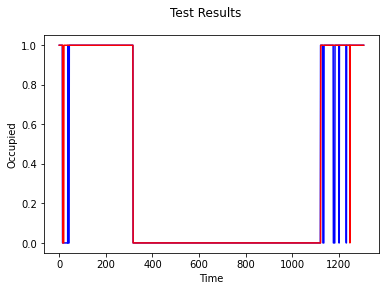

In [ ]:
# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Occupied')
plt.show()

41/41 [==============================] - 0s 2ms/step
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[810  39]
 [  2 457]]
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98       849
         1.0       0.92      1.00      0.96       459

    accuracy                           0.97      1308
   macro avg       0.96      0.97      0.97      1308
weighted avg       0.97      0.97      0.97      1308



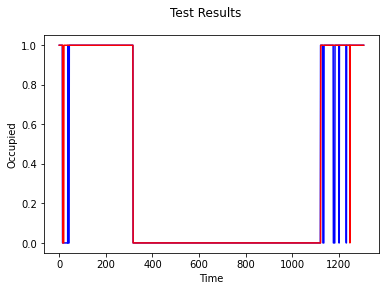

In [ ]:
# put it all together for other models

# make a prediction
pred = model.predict(X_test)# the pred
print(pred) # round them!

pred = np.round(pred,0)
print(pred) # run all if you get an error...

# confusion matrix - put this at the top!
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, pred)) # looks pretty good!
print(classification_report(y_test, pred))

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Occupied')
plt.show()

# RNN two layer model
Don't forget to set return_sequences=True!

In [ ]:
# now let's build a model

# define
n_steps = X_train.shape[1]
n_features = X_train.shape[2]


# define model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, input_shape=(n_steps,n_features))) # notice how input shape goes in first layer
model.add(MaxPooling1D(2))
model.add(Bidirectional(SimpleRNN(30, return_sequences=True, recurrent_dropout=0.2))) # don't forget to return_sequences!
model.add(Bidirectional(SimpleRNN(30, recurrent_dropout=0.2)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])
model.summary()

es = EarlyStopping(monitor='val_acc', mode='max',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 48, 32)            512       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 24, 32)           0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 24, 60)           3780      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60)               5460      
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                      

41/41 [==============================] - 1s 4ms/step
[[0.8689231]
 [0.8689231]
 [0.8689231]
 ...
 [0.8689231]
 [0.8689231]
 [0.8689231]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[824  25]
 [  7 452]]
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       849
         1.0       0.95      0.98      0.97       459

    accuracy                           0.98      1308
   macro avg       0.97      0.98      0.97      1308
weighted avg       0.98      0.98      0.98      1308



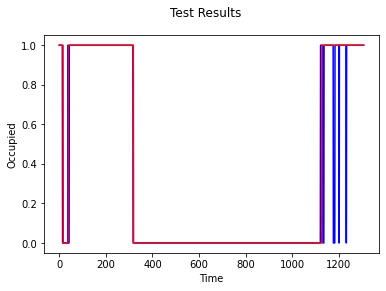

In [ ]:
# put it all together for other models

# make a prediction
pred = model.predict(X_test)# the pred
print(pred) # round them!

pred = np.round(pred,0)
print(pred) # run all if you get an error...

# confusion matrix - put this at the top!
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, pred)) # looks pretty good!
print(classification_report(y_test, pred))

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Occupied')
plt.show()

# LSTM one layer model
Literally, just grab the code above and change SimpleRNN to LSTM and boom! you have a more sophisticated model.

In [ ]:
# define shape
n_steps = X_train.shape[1]
n_features = X_train.shape[2]


# define model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, input_shape=(n_steps,n_features))) # notice how input shape goes in first layer
model.add(MaxPooling1D())
model.add(LSTM(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])
model.summary()

es = EarlyStopping(monitor='val_acc', mode='max',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 48, 32)            512       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 24, 32)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 30)                7560      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 8,103
Trainable params: 8,103
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
210/210 [==============================] - 3s 8ms/step - loss: 16.9076 - acc: 0.5583 - val_loss: 48.6332 -

41/41 [==============================] - 0s 2ms/step
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[804  45]
 [ 15 444]]
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96       849
         1.0       0.91      0.97      0.94       459

    accuracy                           0.95      1308
   macro avg       0.94      0.96      0.95      1308
weighted avg       0.96      0.95      0.95      1308



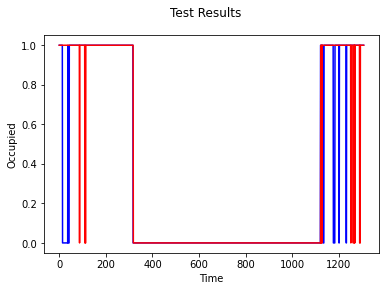

In [ ]:
# put it all together for other models

# make a prediction
pred = model.predict(X_test)# the pred
print(pred) # round them!

pred = np.round(pred,0)
print(pred) # run all if you get an error...

# confusion matrix - put this at the top!
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, pred)) # looks pretty good!
print(classification_report(y_test, pred))

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Occupied')
plt.show()

# LSTM two layer model

In [ ]:
# now let's build a model

# since this is a univariate problem, n_features will be 1 (we also defined this before)

# define model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, input_shape=(n_steps,n_features))) # notice how input shape goes in first layer
model.add(MaxPooling1D(2))
model.add(Bidirectional(LSTM(30,
                            return_sequences=True, # remember, if stacking layers, you need to return sequences!
                            activation='relu',
                            recurrent_dropout=0.2)))
model.add(GRU(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])
model.summary()

es = EarlyStopping(monitor='val_acc', mode='max',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 48, 128)           2048      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 24, 128)          0         
 1D)                                                             
                                                                 
 bidirectional_2 (Bidirectio  (None, 24, 60)           38160     
 nal)                                                            
                                                                 
 gru (GRU)                   (None, 20)                4920      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

41/41 [==============================] - 1s 7ms/step
[[0.997527  ]
 [0.99746627]
 [0.9973637 ]
 ...
 [0.9981714 ]
 [0.99817127]
 [0.998096  ]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[834  15]
 [228 231]]
              precision    recall  f1-score   support

         0.0       0.79      0.98      0.87       849
         1.0       0.94      0.50      0.66       459

    accuracy                           0.81      1308
   macro avg       0.86      0.74      0.76      1308
weighted avg       0.84      0.81      0.80      1308



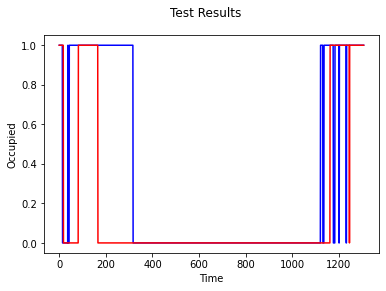

In [ ]:
# put it all together for other models

# make a prediction
pred = model.predict(X_test)# the pred
print(pred) # round them!

pred = np.round(pred,0)
print(pred) # run all if you get an error...

# confusion matrix - put this at the top!
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, pred)) # looks pretty good!
print(classification_report(y_test, pred))

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Occupied')
plt.show()